In [ ]:
# This is a notebook to do some basic data exploration and 
# run some bagging/boosted methods 
# on a sample data set to distinguish between Lyman Alpha Emitting 
# Galaxies and OII Emitting Galaxies.

#Author: Viviana Acquaviva

#License: BSD but really should be TBD - just be nice.

### Bagging and Boosting Methods

Random Forests and XGBoost!

In [1]:
import pandas as pd
import numpy as np
import time
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
    GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import warnings


#Just to make our life easier!
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Data import

Read the data in a data frame using pandas, take a look at them, check the size of the data set, rename columns to something easier to type.

In [3]:
data = pd.read_csv('LAE_OII_CCA.txt', sep = '\t', comment = '#')

In [4]:
data.head()

,type,wavelength of EL (angstroms),EL flux (erg/cm^2/s),continuum flux density,EW observed
0,LAE,4114.6,1.787900e-16,1.0146,99.516
1,LAE,3869.9,6.304500e-17,0.2145,146.820
2,LAE,3962.6,6.446300e-17,0.2983,113.190
3,LAE,3901.7,1.007500e-16,0.0211,2424.600
4,LAE,3954.3,7.311100e-17,1.0416,36.611


In [7]:
data.count()

type                            5436
wavelength of EL (angstroms)    5436
EL flux (erg/cm^2/s)            5436
continuum flux density          5436
EW observed                     5436
dtype: int64

In [8]:
data.columns =['type', 'wavelength', 'ELflux', 'continuum', 'EW']

In [9]:
data.head()

,type,wavelength,ELflux,continuum,EW
0,LAE,4114.6,1.787900e-16,1.0146,99.516
1,LAE,3869.9,6.304500e-17,0.2145,146.820
2,LAE,3962.6,6.446300e-17,0.2983,113.190
3,LAE,3901.7,1.007500e-16,0.0211,2424.600
4,LAE,3954.3,7.311100e-17,1.0416,36.611


### Data exploration

Look at data properties divided by type to figure out some differences between LAEs and OIIs. Change settings to visualize all the columns in a data frame. Eliminate outliers.

In [10]:
data.describe()

,wavelength,ELflux,continuum,EW
count,5436.00000,5.436000e+03,5436.000000,5436.000000
mean,4015.02660,2.449815e-16,68.686761,440.655398
std,112.44312,1.021284e-15,854.380290,3353.032457
min,3800.20000,4.276800e-17,-0.241100,0.008900
25%,3923.27500,5.849275e-17,0.208650,17.725000
50%,4018.35000,7.434850e-17,0.504750,80.634000
75%,4113.52500,1.123825e-16,2.763625,188.425000
max,4200.00000,3.426100e-14,41370.000000,157450.000000


In [12]:
data.groupby('type').describe()

wavelength                                                            \
          count         mean         std     min      25%     50%     75%   
type                                                                        
LAE      4415.0  4003.127475  112.761281  3800.2  3908.35  3999.6  4103.1   
OII      1021.0  4066.480705   95.303749  3826.2  3998.80  4085.8  4148.2   

              ELflux                ... continuum               EW  \
         max   count          mean  ...       75%      max   count   
type                                ...                              
LAE   4200.0  4415.0  8.005258e-17  ...    0.8817   2669.9  4415.0   
OII   4199.8  1021.0  9.581660e-16  ...  149.6100  41370.0  1021.0   

                                                                              
            mean          std     min     25%       50%      75%         max  
type                                                                          
LAE   540.767356  3713.490362  0.0304  48.295  111.1700  219.205  157450.000  
OII     7.752076     8.049062  0.0089   2.110    5.1784   10.639      69.723  

[2 rows x 32 columns]

In [13]:
pd.set_option('display.max_columns', 500)

In [14]:
data.groupby('type').describe()

wavelength                                                            \
          count         mean         std     min      25%     50%     75%   
type                                                                        
LAE      4415.0  4003.127475  112.761281  3800.2  3908.35  3999.6  4103.1   
OII      1021.0  4066.480705   95.303749  3826.2  3998.80  4085.8  4148.2   

              ELflux                                                          \
         max   count          mean           std           min           25%   
type                                                                           
LAE   4200.0  4415.0  8.005258e-17  3.630592e-17  4.276800e-17  5.655650e-17   
OII   4199.8  1021.0  9.581660e-16  2.219254e-15  4.495600e-17  1.125200e-16   

                                               continuum              \
               50%           75%           max     count        mean   
type                                                                   
LAE   6.891900e-17  9.028000e-17  4.380200e-16    4415.0    3.095571   
OII   2.738200e-16  7.966100e-16  3.426100e-14    1021.0  352.315656   

                                                                    EW  \
              std     min      25%      50%       75%      max   count   
type                                                                     
LAE     58.841667 -0.2411   0.1744   0.3545    0.8817   2669.9  4415.0   
OII   1943.049897  0.6176  11.0200  35.0440  149.6100  41370.0  1021.0   

                                                                              
            mean          std     min     25%       50%      75%         max  
type                                                                          
LAE   540.767356  3713.490362  0.0304  48.295  111.1700  219.205  157450.000  
OII     7.752076     8.049062  0.0089   2.110    5.1784   10.639      69.723

In [15]:
data.groupby('type').describe(percentiles = [])

wavelength                                                   ELflux  \
          count         mean         std     min     50%     max   count   
type                                                                       
LAE      4415.0  4003.127475  112.761281  3800.2  3999.6  4200.0  4415.0   
OII      1021.0  4066.480705   95.303749  3826.2  4085.8  4199.8  1021.0   

                                                                            \
              mean           std           min           50%           max   
type                                                                         
LAE   8.005258e-17  3.630592e-17  4.276800e-17  6.891900e-17  4.380200e-16   
OII   9.581660e-16  2.219254e-15  4.495600e-17  2.738200e-16  3.426100e-14   

     continuum                                                         EW  \
         count        mean          std     min      50%      max   count   
type                                                                        
LAE     4415.0    3.095571    58.841667 -0.2411   0.3545   2669.9  4415.0   
OII     1021.0  352.315656  1943.049897  0.6176  35.0440  41370.0  1021.0   

                                                             
            mean          std     min       50%         max  
type                                                         
LAE   540.767356  3713.490362  0.0304  111.1700  157450.000  
OII     7.752076     8.049062  0.0089    5.1784      69.723

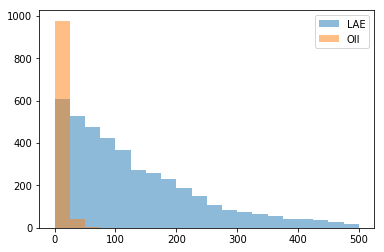

In [17]:
plt.hist(data[data.type == 'LAE']['EW'], bins = 20, range = (0,500), alpha = 0.5, label = 'LAE');
plt.hist(data[data.type == 'OII']['EW'], bins = 20, range = (0,500), alpha = 0.5, label = 'OII');
plt.legend();

In [18]:
seldata = data[(np.abs(stats.zscore(data.drop(['type'],axis=1))) < 3).all(axis=1)]

In [19]:
seldata.shape, data.shape

((5342, 5), (5436, 5))

In [20]:
seldata.groupby('type').describe()

wavelength                                                           \
          count         mean         std     min     25%     50%     75%   
type                                                                       
LAE      4405.0  4003.180499  112.742738  3800.2  3908.4  3999.6  4103.1   
OII       937.0  4070.191889   92.860764  3826.2  4002.5  4089.3  4149.4   

              ELflux                                                          \
         max   count          mean           std           min           25%   
type                                                                           
LAE   4200.0  4405.0  8.001918e-17  3.624174e-17  4.276800e-17  5.654600e-17   
OII   4199.8   937.0  5.076188e-16  6.581478e-16  4.495600e-17  1.039400e-16   

                                               continuum              \
               50%           75%           max     count        mean   
type                                                                   
LAE   6.890100e-17  9.029900e-17  4.380200e-16    4405.0    1.894401   
OII   2.401000e-16  6.004000e-16  3.306200e-15     937.0  117.992090   

                                                                  EW  \
             std     min      25%     50%       75%      max   count   
type                                                                   
LAE    16.136510 -0.2411   0.1753   0.355    0.8821   873.64  4405.0   
OII   254.753536  0.6176  10.0490  28.402  101.0600  2184.10   937.0   

                                                                              
            mean          std     min      25%       50%      75%        max  
type                                                                          
LAE   418.844450  1515.982457  0.0522  48.2520  111.0500  218.310  10258.000  
OII     7.901651     8.120390  0.0394   2.1635    5.4446   10.855     69.723

### Transform pandas data frame into a numpy array that can be fed to sklearn methods, create feature and target arrays, and standardize (not necessary for tree-based).

In [21]:
le = LabelEncoder()

In [22]:
newcol = le.fit_transform(seldata.type.values)

In [23]:
newcol

array([0, 0, 0, ..., 1, 0, 0])

In [24]:
# Note: this assigns the positive (OII) and negative (LAE) class! 
# Need to check and if necessary, flip.

seldata.ix[:,'type'] = newcol

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
seldata.head()

,type,wavelength,ELflux,continuum,EW
0,0,4114.6,1.787900e-16,1.0146,99.516
1,0,3869.9,6.304500e-17,0.2145,146.820
2,0,3962.6,6.446300e-17,0.2983,113.190
3,0,3901.7,1.007500e-16,0.0211,2424.600
4,0,3954.3,7.311100e-17,1.0416,36.611


In [26]:
X, y = seldata.drop('type',axis=1), seldata.type

In [27]:
normalized_X = (X - X.mean())/X.std()

In [28]:
normalized_X.describe()

,wavelength,ELflux,continuum,EW
count,5.342000e+03,5.342000e+03,5.342000e+03,5.342000e+03
mean,4.764307e-14,7.272356e-16,-3.351868e-16,2.660212e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.909843e+00,-3.490171e-01,-1.933709e-01,-2.502623e-01
25%,-8.145499e-01,-3.007989e-01,-1.895221e-01,-2.361628e-01
50%,2.548601e-02,-2.526010e-01,-1.870733e-01,-1.905579e-01
75%,8.766394e-01,-1.415343e-01,-1.708365e-01,-1.132138e-01
max,1.645968e+00,9.797628e+00,1.857999e+01,7.153828e+00


## Ensemble Method 1: Random Forests

Let's start with a RF Classifier with standard parameters, use cross_val_score and cross_val_predict; visualize and plot the confusion matrix.

In [29]:
model = RandomForestClassifier()

In [34]:
cv = StratifiedKFold(shuffle = True, n_splits =5)

In [36]:
scores = cross_val_score(model, normalized_X, y, cv = cv, scoring = 'recall')

In [37]:
scores.mean(), scores.std()


(0.8164523836613948, 0.024503265438934243)

In [39]:
#Verify precision and recall

cross_val_score(model, normalized_X, y, cv = cv, scoring = 'precision')

array([0.86746988, 0.87647059, 0.84831461, 0.88484848, 0.87845304])

In [40]:
ypred = cross_val_predict(model, normalized_X, y, cv = cv)

In [41]:
cm = metrics.confusion_matrix(y, ypred)

Confusion matrix, without normalization


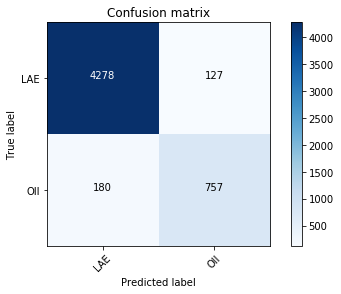

In [42]:
plot_confusion_matrix(cm, classes = ['LAE','OII'])

### We can look at the ROC/AUC by using the "predict_proba" feature.

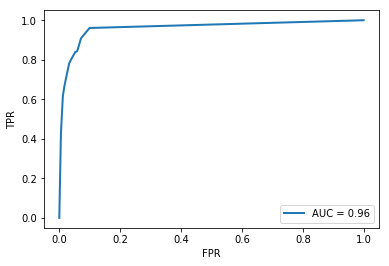

In [44]:
#I need to call "fit" explicitly to do this, so I am defining a train/test split

#Inspired by https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=5)

probas = model.fit(Xtrain, ytrain).predict_proba(Xtest) #doing only on one fold

# Compute ROC curve and area under the curve

fpr, tpr, thresholds = metrics.roc_curve(ytest, probas[:, 1])

roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, lw=2, label = 'AUC = %0.2f' % roc_auc)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend();


### Feature ranking

After the model has been fit, it will have the attribute "feature\_importances\_". We can look at the feature importance using the following code:

In [45]:
model.fit(normalized_X,y) #note: this is not doing any train/test split, but fitting the entire data set 

model.feature_importances_

array([0.09225265, 0.24852438, 0.28194544, 0.37727754])

The code below plots the feature importances.

Feature ranking:
1. feature: EW, 3 (0.377278)
2. feature: continuum, 2 (0.281945)
3. feature: ELflux, 1 (0.248524)
4. feature: wavelength, 0 (0.092253)


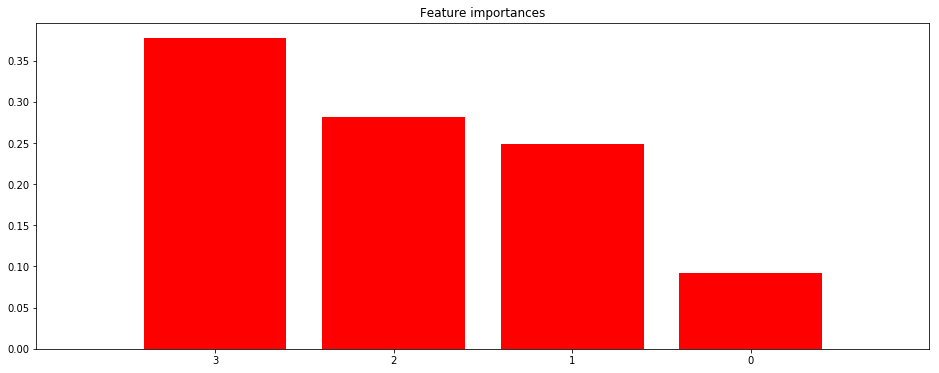

In [46]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(normalized_X.shape[1]):
    print("%d. feature: %s, %d (%f)" % (f + 1, normalized_X.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(normalized_X.shape[1]), indices)
plt.xlim([-1, normalized_X.shape[1]])
plt.show()

We need to take it with a grain of salt (especially when we have only a few) because information is often split if features are not independent.

### How to improve?

In [47]:
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Tree Parameters

The parameters associated to that are:

-  The minimum number of instances in a leaf node;

-  The minimum number of instances required in a split node;

- The maximum depth of tree.

-  The criterion chosen to decide whether a split is "worth it", expressed in terms of information gain;


#### Randomization Parameters

- The number of k < n features that are used in building trees.

- The re-sampling (boostrap) of the data set


#### Forest Parameters

The number of trees in the forest (n_estimators) can be adjusted, with the general understanding that more trees are better, but at some point performance will plateau, so one can find the trade-off between having more trees and lower runtime.

<b> TASKS (10 minutes) </b> 

-  Play with your favorite parameters to see if you can beat the benchmark performance above.

-  Now do the same thing, but using recall as your scoring method.

In [48]:
cvmethod = StratifiedKFold(n_splits=5)
parameters = {'max_depth':[3,5,8], \
              'max_features': [2,4], 'n_estimators':[10,20,50],
             'class_weight':[{1:1},{1:3},{1:5}]}
nmodels = np.product([len(el) for el in parameters.values()])

In [50]:
model = GridSearchCV(RandomForestClassifier(), parameters, cv = cvmethod, \
                     scoring = 'recall', \
    verbose = 1, n_jobs = 4)
start = time.time()
model.fit(normalized_X, y)
stop = time.time()
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_),
print('Time per model (s):', "{:.4f}".format((stop-start)/float(nmodels*4)))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.6s


Best params, best score: 0.9680 {'class_weight': {1: 5}, 'max_depth': 3, 'max_features': 2, 'n_estimators': 20}
Time per model (s): 0.0855


[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:   18.4s finished


In [51]:
model = GridSearchCV(RandomForestClassifier(), parameters, cv = cvmethod, \
                     scoring = 'accuracy', \
    verbose = 1, n_jobs = 4)
start = time.time()
model.fit(normalized_X, y)
stop = time.time()
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_),
print('Time per model (s):', "{:.4f}".format((stop-start)/float(nmodels*4)))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    7.6s


Best params, best score: 0.9489 {'class_weight': {1: 1}, 'max_depth': 3, 'max_features': 4, 'n_estimators': 10}
Time per model (s): 0.0682


[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:   14.7s finished


### Ensemble methods 2: Gradient Boosting Models

Gradient Boosting models are another ensemble method where weak learners (usually decision stumps) are combined together.

Unlike Random Forests, the model is built by <b> adding individual trees in a sequential fashion, </b>
but choosing which trees we add to the model in a way that minimizes the current loss function. The "Gradient" part refers to the fact that we try to move along the gradient of the objective function (by calculating its numerical derivative) as we add more trees.

The parameters depend on the particular implementation.

In the sklearn formulation, the parameters of each tree are essentially the same we saw above; additionally we have the "learning_rate" parameter, which dictates how much each tree contribute to the final estimator, and the "subsample" parameters, which allows one to use a < 1.0 fraction of samples.

I liked this blog post about parameter tuning for GBMs:

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

#### We'll do the usual benchmarking with cross_val_score and check differences with RF:

In [54]:
model2 = GradientBoostingClassifier()

In [57]:
scores2 = cross_val_score(model2, normalized_X, y, cv = cv, scoring = 'recall')

In [58]:
scores2.mean(), scores2.std()

(0.8388383206280577, 0.006445393757705936)

<b> TASKS (10 minutes) </b>

-  Use the get_params() method to find out the names and signatures of different parameters, and their default values.

-  Play with your favorite parameters to see how much you can improve the benchmark performance above.

-  Compare the timings to Random Forests.

In [59]:
model2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [61]:
parameters = {'max_depth':[1,3,5], 'learning_rate': [0.1, 0.3, 0.5], 'n_estimators': [50, 100, 200]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(GradientBoostingClassifier(), parameters, \
                cv = cvmethod, scoring = 'accuracy', verbose = 1, n_jobs = 4)
start = time.time()
model.fit(normalized_X,y)
stop = time.time()
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_),
print('Time per model (s):', "{:.4f}".format((stop-start)/float(nmodels*4)))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  62 tasks      | elapsed:    8.4s


Best params, best score: 0.9493 {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
Time per model (s): 0.1930


[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:   20.7s finished


### Subtleties in parameter optimization (we'll see some today)

-  Use cv_results to look at gradients along parameters and build understanding;

-  Push the edges of your parameter grid search; 

-  Do nested cross validation to evaluate the generalization error in order to avoid leakage between the parameter optimization and the cross validation procedure. 

### My advice: Define your own evaluation metric 

This is an example of what we did for this paper (Leung, VA et al 2016), where x0 = 1 - precision and x1 = 1 - recall.

<img src="Formula_Leung.jpg" width="300"/>


#### How to do that in code?

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
def my_loss_func(y, ypred):
    return np.log(1+np.abs(y-ypred).max())

In [ ]:
model = RandomForestClassifier()

In [ ]:
cross_val_score(model, normalized_X, y, cv = cvmethod, \
               scoring = make_scorer(my_loss_func, greater_is_better=False))

### Summary

Take a look at your data before you start building models.

Which algorithm is best, and how you will optimize it, really depends on what you are trying to do.

Define your own evaluation metric and/or pick the one that works best for your problem and your data.

### Exercises :) 

### 1. Try out xgboost (vs sklearn's GBM)

Sometimes knowns as "regularized" GBM, more robust to overfitting.

Has more flexibility in defining weak learners, and objective function.

Reputation of being very fast.

From the same author as the one above:

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
import xgboost

In [ ]:
model = xgboost.XGBClassifier()

In [ ]:
model.get_params()

### 2. Try out HistGradientBoostingClassifier 

(sklearn's newest implementation, inspired by Microsoft's LightGBM. Promises to be super fast
on large ( > 10,000) data sets, by turning numerical features into bins to limit the number of possible splits. Requires installing sklearn v 0.21.x... I didn't)



In [ ]:
#This is the starter code

# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier


### 3. Compare DT, RF, GBM on same data set (either this one, or variable stars).

Compare performance of RF, GBM to DT out of the box for the variable star data set. Are ensemble methods effective in reducing overfitting?

Note: if you'd like, you can use this handy function "checktraintest" that I wrote to evaluate the difference between train and test scores in a "cross-validate-y" fashion. The standard deviation helps determine if the difference is statistically significant.

In [ ]:
def checktraintest(X, y, model, ntrials =5, test_size = 0.2):
    
    """evaluates the difference between a classifier's train and test scores 
    in a "k-fold-y" fashion. Output means and std to help determine if 
    the difference is statistically significant. """

    scores_train = np.zeros(ntrials)
    scores_test = np.zeros(ntrials)

    for i in range(ntrials):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size, random_state=i)
        model.fit(X_train, y_train)
        pred_test = model.predict(X_test)
        pred_train = model.predict(X_train)

        scores_test[i] = (metrics.accuracy_score(y_test,pred_test))
        scores_train[i] =(metrics.accuracy_score(y_train,pred_train))

    print('Training scores '+str(scores_train.mean())+' +- '+str(scores_train.std()))
    print('Test scores '+str(scores_test.mean())+' +- '+str(scores_test.std()))